# Compositions

In [1]:
import opendp.prelude as dp
dp.enable_features("contrib")

d_in = 1 # input distance
input_metric = dp.symmetric_distance()

d_out = 1 # epsilon
privacy_measure = dp.max_divergence(T=float) # pure dp

# We don't really use what's left below in this code box
######################################################################################

col_names = [
   "name", "sex", "age", "maritalStatus", "hasChildren", "highestEducationLevel", 
   "sourceOfStress", "smoker", "optimism", "lifeSatisfaction", "selfEsteem"
]

import urllib.request
data_url = "https://raw.githubusercontent.com/opendp/opendp/sydney/teacher_survey.csv"
with urllib.request.urlopen(data_url) as data_req:
    data = data_req.read().decode('utf-8')

# Make a queriable
m_sc = dp.c.make_sequential_composition(
    # data set is a single string, with rows separated by linebreaks
    input_domain=dp.atom_domain(T=str),
    input_metric=input_metric,
    output_measure=privacy_measure,
    d_in=d_in,
    d_mids=[d_out / 3] * 3,
)

qbl_sc = m_sc(data)

A transformation and a Gaussian measurement

In [2]:
import opendp as dpf

# Make a query
count_transformation = (
    dp.t.make_split_dataframe(",", col_names=col_names)
    >> dp.t.make_select_column("age", str)
    >> dp.t.then_count()
)
count_sensitivity = count_transformation.map(d_in)

# Add a Gaussian measurement, transform to approximate DP and get SMDCurve
gaussian_scale = 1.0
count_gaussian_measurement = count_transformation >> dp.m.then_gaussian(scale = gaussian_scale)

Composition

In [12]:
import math
import numpy as np
import opendp as dpf
from tradeoff import tradeoffCurve, smdCurveWrapper, get_tradeoff_gaussian
k = 5
alphas = np.arange(0, 1, 0.01)
deltas = np.arange(0, 1, 0.001)

# With zeroCDP
zCDP_composition = dpf.combinators.make_basic_composition([count_gaussian_measurement for i in range(k)])
composition_zcdp_smd = dpf.combinators.make_zCDP_to_approxDP(zCDP_composition)
composition_zcdp_smd_smd_curve = composition_zcdp_smd.map(count_sensitivity)
composition_zcdp_smd_tradeoff = tradeoffCurve(smdCurveWrapper(composition_zcdp_smd_smd_curve), deltas=deltas)


# With f-DP (from corollary 3.3 in Gaussian dp paper)
mu = count_sensitivity / gaussian_scale
composition_fdp_mu_gaussian = math.sqrt(k * mu**2)
composition_fdp_tradeoff = get_tradeoff_gaussian(composition_fdp_mu_gaussian)


In [13]:
betas_compostion_zcdp_smd = [composition_zcdp_smd_tradeoff(alpha) for alpha in alphas]
betas_composition_fdp = [composition_fdp_tradeoff(alpha) for alpha in alphas]


/mnt/data/research/opendp/opendp-relative-risk/tradeoff.py:9: RuntimeWarning: invalid value encountered in scalar multiply
  left = 1 - delta - (math.exp(eps) * alpha)


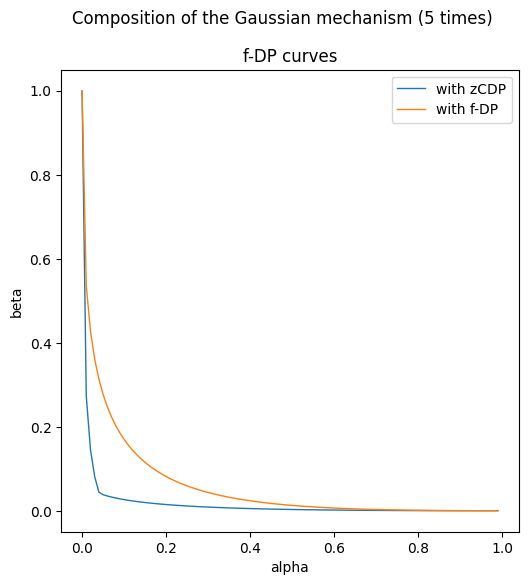

In [14]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle("Composition of the Gaussian mechanism (5 times)")

ax1.plot(alphas, betas_compostion_zcdp_smd, label='with zCDP', marker='', linewidth=1)
ax1.plot(alphas, betas_composition_fdp, label='with f-DP', marker='', linewidth=1)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
ax1.set_title('f-DP curves')
ax1.legend()
ax1.set_aspect('equal')

plt.show()


In [18]:
from relative_risk import posterior, relative_risk

priors = [0.1, 0.2, 0.5, 0.9, 0.99]

posts_composition_zcdp_smd = []
rrisk_composition_zcdp_smd = []
for prior in priors:
    post = [posterior(alpha, composition_zcdp_smd_tradeoff, prior) for alpha in alphas]
    posts_composition_zcdp_smd.append(post)
    rrisk = [relative_risk(alpha, composition_zcdp_smd_tradeoff, prior) for alpha in alphas]
    rrisk_composition_zcdp_smd.append(rrisk)

posts_composition_fdp = []
rrisk_composition_fdp = []
for prior in priors:
    post = [posterior(alpha, composition_fdp_tradeoff, prior) for alpha in alphas]
    posts_composition_fdp.append(post)
    rrisk = [relative_risk(alpha, composition_fdp_tradeoff, prior) for alpha in alphas]
    rrisk_composition_fdp.append(rrisk)

/mnt/data/research/opendp/opendp-relative-risk/tradeoff.py:9: RuntimeWarning: invalid value encountered in scalar multiply
  left = 1 - delta - (math.exp(eps) * alpha)
/mnt/data/research/opendp/opendp-relative-risk/relative_risk.py:5: RuntimeWarning: invalid value encountered in scalar divide
  posterior = (prior * (1 - beta)) / ((1 - prior)*alpha + prior * (1 - beta))
/mnt/data/research/opendp/opendp-relative-risk/relative_risk.py:12: RuntimeWarning: invalid value encountered in scalar divide
  relative_risk = (1 - beta) / ((1 - prior)*alpha + prior * (1 - beta))


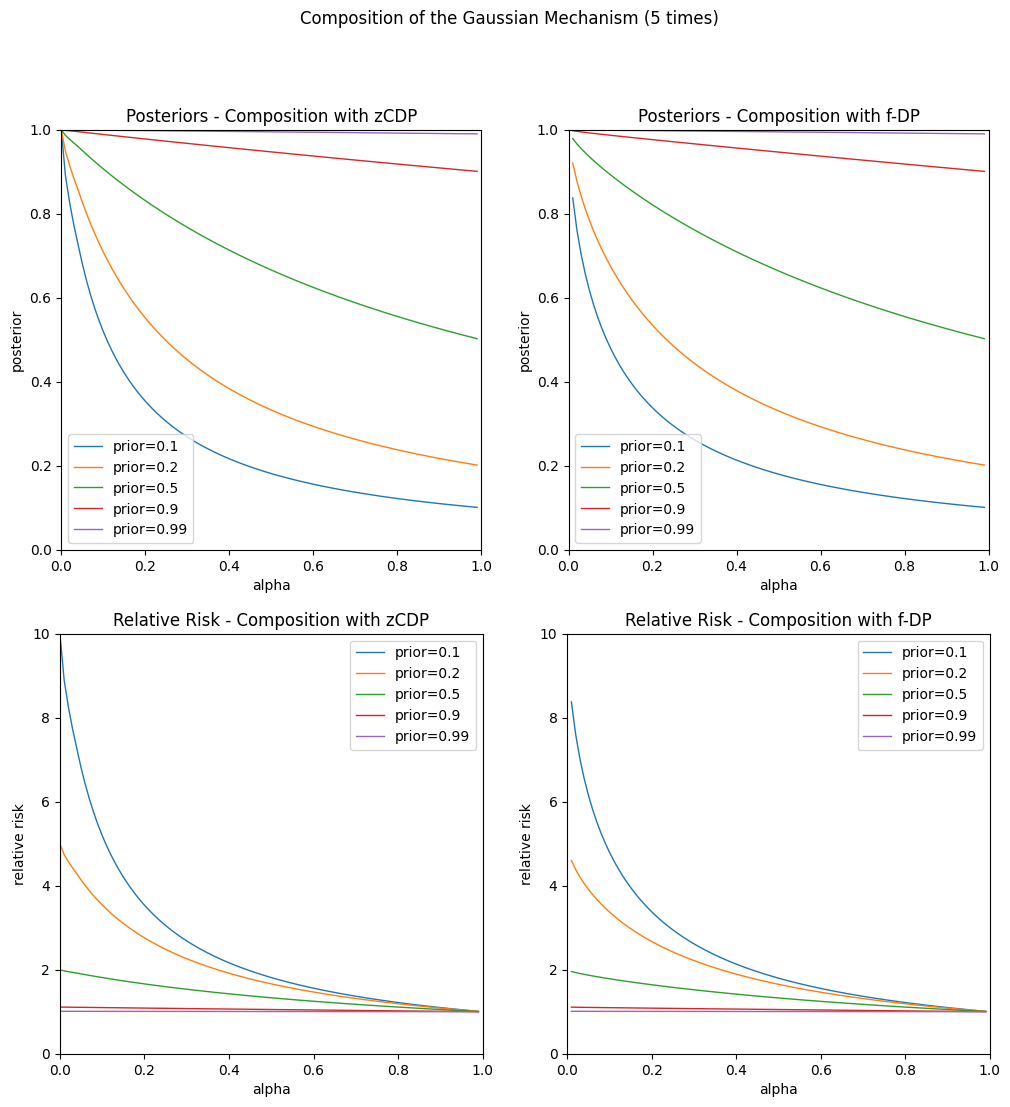

In [20]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Composition of the Gaussian Mechanism (5 times)")

ax1.set_title('Posteriors - Composition with zCDP')
for i in range(0, len(priors)):
    ax1.plot(alphas, posts_composition_zcdp_smd[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax1.set_xlabel('alpha')
ax1.set_ylabel('posterior')
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_aspect('equal')

ax2.set_title('Posteriors - Composition with f-DP')
for i in range(0, len(priors)):
    ax2.plot(alphas, posts_composition_fdp[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax2.set_xlabel('alpha')
ax2.set_ylabel('posterior')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.legend()
ax2.set_aspect('equal')

ax3.set_title('Relative Risk - Composition with zCDP')
for i in range(0, len(priors)):
    ax3.plot(alphas, rrisk_composition_zcdp_smd[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax3.set_xlabel('alpha')
ax3.set_ylabel('relative risk')
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 10)
ax3.legend()

ax4.set_title('Relative Risk - Composition with f-DP')
for i in range(0, len(priors)):
    pass
    ax4.plot(alphas, rrisk_composition_fdp[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax4.set_xlabel('alpha')
ax4.set_ylabel('relative risk')
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 10)
ax4.legend()
